# Data Wrangling - Food 101 Dataset

### Import packages

In [1]:
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img

# Show plot inside notebook
%matplotlib inline

import pandas as pd
print('Pandas version:', pd.__version__)

# Set Jupyter notebook display options
pd.options.display.max_rows = 8
pd.options.display.max_columns = 8

Pandas version: 0.24.2


### Explore folder structure

In [2]:
# root image path of the dataset
FOOD_IMAGE_PATH = Path('../datasets/food-101/images')
FOOD_IMAGE_FILE_EXT = '.jpg'

# meta path of the dataset
FOOD_META_PATH = Path('../datasets/food-101/meta')

In [3]:
# list food classes
class_paths = sorted([path.name for path in FOOD_IMAGE_PATH.iterdir() if path.is_dir()])

for index, path in enumerate(class_paths):
    print(index + 1, path)

1 apple_pie
2 baby_back_ribs
3 baklava
4 beef_carpaccio
5 beef_tartare
6 beet_salad
7 beignets
8 bibimbap
9 bread_pudding
10 breakfast_burrito
11 bruschetta
12 caesar_salad
13 cannoli
14 caprese_salad
15 carrot_cake
16 ceviche
17 cheese_plate
18 cheesecake
19 chicken_curry
20 chicken_quesadilla
21 chicken_wings
22 chocolate_cake
23 chocolate_mousse
24 churros
25 clam_chowder
26 club_sandwich
27 crab_cakes
28 creme_brulee
29 croque_madame
30 cup_cakes
31 deviled_eggs
32 donuts
33 dumplings
34 edamame
35 eggs_benedict
36 escargots
37 falafel
38 filet_mignon
39 fish_and_chips
40 foie_gras
41 french_fries
42 french_onion_soup
43 french_toast
44 fried_calamari
45 fried_rice
46 frozen_yogurt
47 garlic_bread
48 gnocchi
49 greek_salad
50 grilled_cheese_sandwich
51 grilled_salmon
52 guacamole
53 gyoza
54 hamburger
55 hot_and_sour_soup
56 hot_dog
57 huevos_rancheros
58 hummus
59 ice_cream
60 lasagna
61 lobster_bisque
62 lobster_roll_sandwich
63 macaroni_and_cheese
64 macarons
65 miso_soup
66 mus

In [4]:
# list 10 images inside a sample food class; suffix D for directory or F for file
class_path = FOOD_IMAGE_PATH / 'waffles'
for index, item in enumerate(class_path.iterdir()):
    if index >= 10:
        break
    
    print(index + 1, item.name, 'D' if item.is_dir() else 'F')

1 795262.jpg F
2 1203560.jpg F
3 764669.jpg F
4 1351305.jpg F
5 3159868.jpg F
6 3854229.jpg F
7 311361.jpg F
8 720603.jpg F
9 1161643.jpg F
10 3855881.jpg F


### Display some random images from each food class

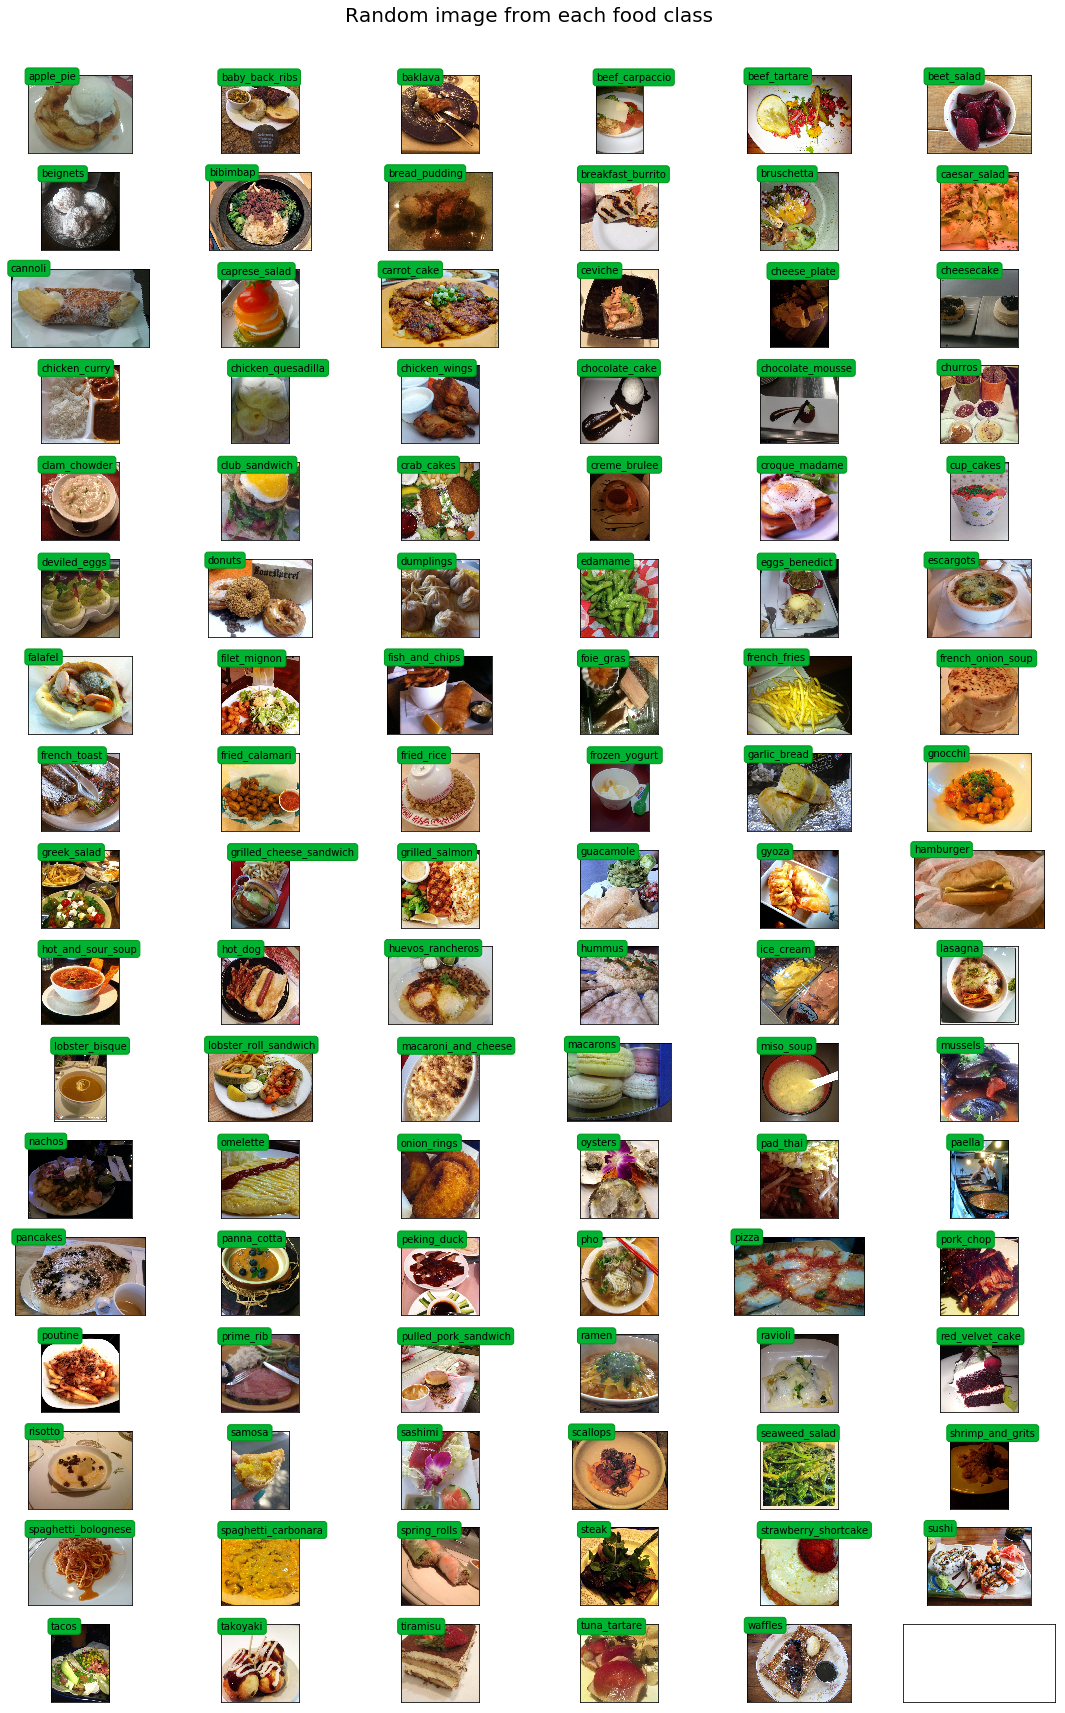

In [5]:
rows = 17
cols = 6

fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random image from each food class', fontsize=20)

for i in range(rows):
    for j in range(cols):
        try:
            class_name = class_paths[i * cols + j]
        except:  # 17 * 6 = 102, so the last plot is blank
            break
            
        class_path = FOOD_IMAGE_PATH / class_name
        class_files = [file.name for file in class_path.iterdir() if file.is_file()]
        random_file = np.random.choice(class_files)
        
        random_image = plt.imread(class_path / random_file)
        ax[i][j].imshow(random_image)
        
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, class_name, size=10, rotation=0, ha='left', va='top', bbox=dict(boxstyle='round', ec=ec, fc=fc))
        
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Load labels and classes

In [6]:
classes_df = pd.read_csv(FOOD_META_PATH / 'classes.txt', header=None, names=['class'])
classes_df.head()

,class
0,apple_pie
1,baby_back_ribs
2,baklava
3,beef_carpaccio
4,beef_tartare


In [7]:
labels_df = pd.read_csv(FOOD_META_PATH / 'labels.txt', header=None, names=['label'])
labels_df.head()

,label
0,Apple pie
1,Baby back ribs
2,Baklava
3,Beef carpaccio
4,Beef tartare


In [8]:
# data validation
assert classes_df.shape[0] == 101, 'Number of food classes must be exact 101'
assert classes_df.shape[0] == labels_df.shape[0], 'Mismatched number of food classes and their labels'

In [9]:
# combine class and label columns, make class an index after this
food_df = pd.concat([classes_df, labels_df], axis=1).set_index('class')
food_df.head()

,label
class,
apple_pie,Apple pie
baby_back_ribs,Baby back ribs
baklava,Baklava
beef_carpaccio,Beef carpaccio
beef_tartare,Beef tartare


In [10]:
# data validation
assert food_df.shape == (101, 1), 'Number of food classes must be exact 101'

### Load training data

In [11]:
def extract_class_image(row):
    image_cell = row['image']
    parts = image_cell.split('/')
    
    row['class'] = ''
    if len(parts) < 2:
        return row
    
    image_path = f'{image_cell}{FOOD_IMAGE_FILE_EXT}'
    image_file = FOOD_IMAGE_PATH / image_path
    if not image_file.exists() or not image_file.is_file():
        return row
    
    image_size = image_file.stat().st_size
    if image_size < 100:
        return row
    
    row['class'] = parts[0]
    row['image'] = image_path

    return row

In [12]:
train_df = pd.read_csv(FOOD_META_PATH / 'train.txt', header=None, names=['image'])
train_df.head()

,image
0,apple_pie/1005649
1,apple_pie/1014775
2,apple_pie/1026328
3,apple_pie/1028787
4,apple_pie/1043283


In [13]:
# parse the temp column into class and image columns
%time train_df = train_df.apply(extract_class_image, axis=1)

CPU times: user 1min 59s, sys: 2.46 s, total: 2min 2s
Wall time: 2min 6s


**Kinda slow, can PySpark improve?**

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75750 entries, 0 to 75749
Data columns (total 2 columns):
image    75750 non-null object
class    75750 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


**There are no missing class values and invalid image files**

In [15]:
# set class as index
train_df = train_df.set_index('class')
train_df.head()

,image
class,
apple_pie,apple_pie/1005649.jpg
apple_pie,apple_pie/1014775.jpg
apple_pie,apple_pie/1026328.jpg
apple_pie,apple_pie/1028787.jpg
apple_pie,apple_pie/1043283.jpg


In [16]:
# data validation
assert train_df.shape == (75750, 1), 'Train data has less samples than expected'

### Load test data

In [17]:
test_df = pd.read_csv(FOOD_META_PATH / 'test.txt', header=None, names=['image'])
%time test_df = test_df.apply(extract_class_image, axis=1)

CPU times: user 39 s, sys: 364 ms, total: 39.4 s
Wall time: 39.5 s


In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25250 entries, 0 to 25249
Data columns (total 2 columns):
image    25250 non-null object
class    25250 non-null object
dtypes: object(2)
memory usage: 394.6+ KB


**There are no missing class values and invalid image files**

In [19]:
# set class as index
test_df = test_df.set_index('class')
test_df.head()

,image
class,
apple_pie,apple_pie/1011328.jpg
apple_pie,apple_pie/101251.jpg
apple_pie,apple_pie/1034399.jpg
apple_pie,apple_pie/103801.jpg
apple_pie,apple_pie/1038694.jpg


In [20]:
# data validation
assert test_df.shape == (25250, 1), 'Test data has less samples than expected'

### Merge train and test data to the main dataset

In [21]:
# train data
train_df = pd.merge(train_df, food_df, how='right', on='class')

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75750 entries, apple_pie to waffles
Data columns (total 2 columns):
image    75750 non-null object
label    75750 non-null object
dtypes: object(2)
memory usage: 1.7+ MB


In [23]:
print(train_df.head(10))
print(train_df.tail(10))

                           image      label
class                                      
apple_pie  apple_pie/1005649.jpg  Apple pie
apple_pie  apple_pie/1014775.jpg  Apple pie
apple_pie  apple_pie/1026328.jpg  Apple pie
apple_pie  apple_pie/1028787.jpg  Apple pie
...                          ...        ...
apple_pie  apple_pie/1057749.jpg  Apple pie
apple_pie  apple_pie/1057810.jpg  Apple pie
apple_pie  apple_pie/1072416.jpg  Apple pie
apple_pie  apple_pie/1074856.jpg  Apple pie

[10 rows x 2 columns]
                      image    label
class                               
waffles  waffles/961486.jpg  Waffles
waffles   waffles/97524.jpg  Waffles
waffles   waffles/97567.jpg  Waffles
waffles  waffles/978448.jpg  Waffles
...                     ...      ...
waffles   waffles/98238.jpg  Waffles
waffles  waffles/982668.jpg  Waffles
waffles  waffles/995085.jpg  Waffles
waffles  waffles/999047.jpg  Waffles

[10 rows x 2 columns]


In [24]:
# test data
test_df = pd.merge(test_df, food_df, how='right', on='class')

In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25250 entries, apple_pie to waffles
Data columns (total 2 columns):
image    25250 non-null object
label    25250 non-null object
dtypes: object(2)
memory usage: 591.8+ KB


In [26]:
print(test_df.head(10))
print(test_df.tail(10))

                           image      label
class                                      
apple_pie  apple_pie/1011328.jpg  Apple pie
apple_pie   apple_pie/101251.jpg  Apple pie
apple_pie  apple_pie/1034399.jpg  Apple pie
apple_pie   apple_pie/103801.jpg  Apple pie
...                          ...        ...
apple_pie  apple_pie/1068632.jpg  Apple pie
apple_pie   apple_pie/110043.jpg  Apple pie
apple_pie  apple_pie/1106961.jpg  Apple pie
apple_pie  apple_pie/1113017.jpg  Apple pie

[10 rows x 2 columns]
                      image    label
class                               
waffles  waffles/901565.jpg  Waffles
waffles  waffles/905007.jpg  Waffles
waffles  waffles/908565.jpg  Waffles
waffles  waffles/913086.jpg  Waffles
...                     ...      ...
waffles  waffles/954028.jpg  Waffles
waffles   waffles/96181.jpg  Waffles
waffles   waffles/97015.jpg  Waffles
waffles  waffles/971843.jpg  Waffles

[10 rows x 2 columns]


In [27]:
# combine new train and test dataframes back to the main food dataframe
food_df = pd.concat([train_df, test_df])

In [28]:
food_df.info()
assert food_df.shape[0] == 101000, 'Number of data sample must be exact 101000'

<class 'pandas.core.frame.DataFrame'>
Index: 101000 entries, apple_pie to waffles
Data columns (total 2 columns):
image    101000 non-null object
label    101000 non-null object
dtypes: object(2)
memory usage: 2.3+ MB


In [29]:
print(food_df.head(10))
print(food_df.tail(10))

                           image      label
class                                      
apple_pie  apple_pie/1005649.jpg  Apple pie
apple_pie  apple_pie/1014775.jpg  Apple pie
apple_pie  apple_pie/1026328.jpg  Apple pie
apple_pie  apple_pie/1028787.jpg  Apple pie
...                          ...        ...
apple_pie  apple_pie/1057749.jpg  Apple pie
apple_pie  apple_pie/1057810.jpg  Apple pie
apple_pie  apple_pie/1072416.jpg  Apple pie
apple_pie  apple_pie/1074856.jpg  Apple pie

[10 rows x 2 columns]
                      image    label
class                               
waffles  waffles/901565.jpg  Waffles
waffles  waffles/905007.jpg  Waffles
waffles  waffles/908565.jpg  Waffles
waffles  waffles/913086.jpg  Waffles
...                     ...      ...
waffles  waffles/954028.jpg  Waffles
waffles   waffles/96181.jpg  Waffles
waffles   waffles/97015.jpg  Waffles
waffles  waffles/971843.jpg  Waffles

[10 rows x 2 columns]


### Save the prepared main food dataframe to CSV file

In [30]:
food_df.to_csv(FOOD_IMAGE_PATH / 'food-101.csv', index=True, encoding='utf-8')